In [ ]:
!nvidia-smi

Sat Oct  9 16:44:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Lista 5
### NCG-040 - Introdução à Visão Computacional


`Nome:` Pedro Henrique Gomes P. Januario

`DRE:` 119042303 

<br>

`Nome:` Mayara Aragão

`DRE:` 115060969 

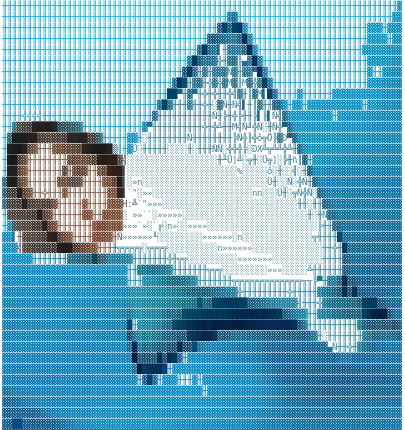


### 0) Instruções

Para esta lista, vamos fazer algo um pouco diferente. Vocês estão livres para escolher um dataset simples e fazer um treinamento de rede neural, conforme visto nas aulas do dia 15, 17 e 22 de Setembro. No mínimo uma tarefa de classificação binária.

Dica: Cats vs Dogs do Kaggle ou similar

# Classificando Nemos:

Com base no apelido amplamante conhecido de um dos integrantes da dupla, 'Mayarraia', decidimos criar um modelo de redes neurais convolucionais para identificacao de especies de peixe. O dataset escolhido foi 'A large scale fish dataset' no kaggle. https://www.kaggle.com/crowww/a-large-scale-fish-dataset

O dataset que trabalharemos consiste de 9 classes(especies) de peixe com 1000 entradas cada. O dataset original ainda possui 1000 imagens 'Ground Truth' para segmentacao, totalizando 2000 entradas para cada especie. Entretanto, nao trabalharemos com essas imagens, faremos apenas a classificacao. Tal dataset passou por augmentation de rotacao e de flip.

### Dependencias:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import pathlib
from sklearn.model_selection import train_test_split

In [ ]:
# Importando dataset atraves da API do kaggle:
from google.colab import files
files.upload() #this will prompt you to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Saving kaggle.json to kaggle.json
kaggle.json
100% 3.23G/3.24G [01:38<00:00, 70.2MB/s]
100% 3.24G/3.24G [01:38<00:00, 35.3MB/s]


In [ ]:
# unzipping:
!unzip -q a-large-scale-fish-dataset.zip -d nemo_dataset

## Organizando o dataset:

In [ ]:
%cd nemo_dataset/Fish_Dataset/Fish_Dataset

/content/nemo_dataset/Fish_Dataset/Fish_Dataset


In [ ]:
!ls

'Black Sea Sprat'   README.txt	     Segmentation_example_script.m
'Gilt-Head Bream'  'Red Mullet'      Shrimp
'Hourse Mackerel'  'Red Sea Bream'  'Striped Red Mullet'
 license.txt	   'Sea Bass'	     Trout


In [ ]:
datasetPath = pathlib.Path()
## Listando os Paths para as imagens, testando extensoes jpg e png
allImages = list(datasetPath.glob(r'*/*/*.jpg')) + list(datasetPath.glob(r'*/*/*.png'))

## Iniciando array das imagens e labels
images = list()
labels = list()

for img in allImages:
  imgPath = os.path.normpath(img)
  splits = imgPath.split('/')
  
  # Excluindo imagens 'Ground Truth' (GT), jogando o caminho das imgs e seus labels para os arrays 'images' e 'labels'
  if 'GT' not in splits[-2]:
    images.append(img)
    labels.append(splits[-2]) # Pegando a Label do proprio Path da imagem

In [ ]:
# Montando o dataframe dos dados:

imgpathes = pd.Series(images).astype(str)
label = pd.Series(labels)

df = pd.concat([imgpathes,label], axis=1)
df.columns = ['Img','Label']
df

Img            Label
0     Gilt-Head Bream/Gilt-Head Bream/00391.png  Gilt-Head Bream
1     Gilt-Head Bream/Gilt-Head Bream/00828.png  Gilt-Head Bream
2     Gilt-Head Bream/Gilt-Head Bream/00419.png  Gilt-Head Bream
3     Gilt-Head Bream/Gilt-Head Bream/00418.png  Gilt-Head Bream
4     Gilt-Head Bream/Gilt-Head Bream/00506.png  Gilt-Head Bream
...                                         ...              ...
8995      Red Sea Bream/Red Sea Bream/00636.png    Red Sea Bream
8996      Red Sea Bream/Red Sea Bream/00077.png    Red Sea Bream
8997      Red Sea Bream/Red Sea Bream/00346.png    Red Sea Bream
8998      Red Sea Bream/Red Sea Bream/00310.png    Red Sea Bream
8999      Red Sea Bream/Red Sea Bream/00726.png    Red Sea Bream

[9000 rows x 2 columns]

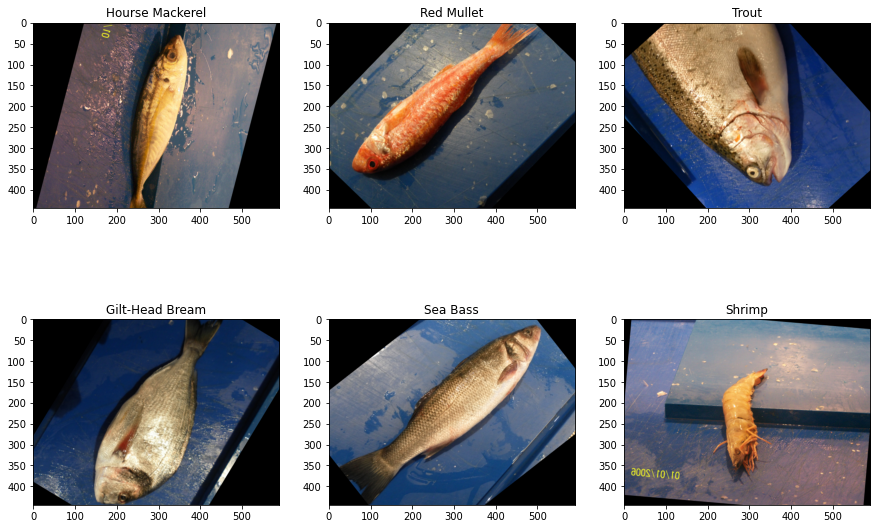

In [ ]:
import random
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for ax in axes.ravel():
  # Pegando um index qualquer entre 0 e (numero de rows do df) -1 (ja que o df comeca a contar do 0):
  randomIndex = random.randint(0,df.shape[0]-1) 
  
  nemo = plt.imread(df['Img'][randomIndex])
  ax.imshow(nemo)
  ax.set_title(df['Label'][randomIndex])

In [ ]:
# Fazendo um shuffle desse dataframe para espalhar as classes:

shuffledDf = df.sample(frac=1,random_state=42)

### Data Augmentation

In [ ]:
# Augmentacao dos dados


# Separando o dataframe em Treino, Validacao e Teste (e mais shuffles)

allTrain, test = train_test_split(shuffledDf,test_size=0.15,random_state=0)
train, validation = train_test_split(allTrain,test_size=0.25,random_state=0)
del allTrain

from keras.preprocessing.image import ImageDataGenerator

# Preparando o objeto para ja fazer normalizacao e uns flips aleatorios

imgDataGenObject = ImageDataGenerator(rescale=1.0/255,
                                      horizontal_flip=True,
                                      vertical_flip=True)

# Gerando os geradores:

train_generator = imgDataGenObject.flow_from_dataframe(dataframe=train,
                                                       x_col='Img',y_col='Label',
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       target_size=(224,224),
                                                       batch_size=64)
#----------------------------------
validation_generator = imgDataGenObject.flow_from_dataframe(dataframe=validation,
                                                       x_col='Img',y_col='Label',
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       target_size=(224,224),
                                                       batch_size=64)

#----------------------------------
test_generator = imgDataGenObject.flow_from_dataframe(dataframe=test,
                                                       x_col='Img',y_col='Label',
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       target_size=(224,224),
                                                       batch_size=64,
                                                      shuffle=False)

# COOL

Found 5737 validated image filenames belonging to 9 classes.
Found 1913 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


# Preparando o modelo CNN

In [ ]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,Flatten,Dense,Dropout

In [ ]:
nemo_finder = Sequential()

# Layers

nemo_finder.add(Conv2D(32,kernel_size=(4,4),activation='relu',input_shape=(224,224,3)))
nemo_finder.add(MaxPool2D()) # Utilizando poolsize default de 2x2

# ----------------
nemo_finder.add(Conv2D(64,kernel_size=(4,4),activation='relu'))
nemo_finder.add(Conv2D(64,kernel_size=(4,4),activation='relu'))
nemo_finder.add(MaxPool2D())

# ----------------
nemo_finder.add(Conv2D(128,kernel_size=(4,4),activation='relu'))
nemo_finder.add(Conv2D(128,kernel_size=(4,4),activation='relu'))
nemo_finder.add(MaxPool2D())

#-----------------
nemo_finder.add(Conv2D(256,kernel_size=(4,4),activation='relu'))
nemo_finder.add(Conv2D(256,kernel_size=(4,4),activation='relu'))
nemo_finder.add(MaxPool2D())

# ----------------
nemo_finder.add(Flatten())

# ----------------
nemo_finder.add(Dense(256,activation='relu'))

# ----------------
# Dropout de 40% para tentar reduzir um pouco o overfit
nemo_finder.add(Dropout(0.4))

# ----------------
# 9 classes -> 9 neurons softmax
nemo_finder.add(Dense(9,activation='softmax'))


In [ ]:
nemo_finder.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
nemo_finder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 64)      65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 128)       131200    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 128)       2

In [ ]:
from keras.callbacks import EarlyStopping

# Para o treinamento quando nao houver melhora nas metricas passadas, onde o numero de epochs de tolerancia (Ex: modelo pode aceitar ate 3 epochs sem mudanca positiva) 
# eh definido pelo parametro patience
earlyStop = EarlyStopping(monitor='loss',patience=3,restore_best_weights=True) # Restora os pesos relacionados ao melhor valor da metrica passada

fit = nemo_finder.fit(train_generator,
                      validation_data=validation_generator,
                      epochs=15,callbacks=earlyStop)
nemo_finder.save('nemo_finder.h5')


Epoch 1/15
90/90 [==============================] - 135s 1s/step - loss: 2.5974 - accuracy: 0.1206 - val_loss: 2.2774 - val_accuracy: 0.1448
Epoch 2/15
90/90 [==============================] - 91s 1s/step - loss: 2.2761 - accuracy: 0.1238 - val_loss: 2.1806 - val_accuracy: 0.1464
Epoch 3/15
90/90 [==============================] - 91s 1s/step - loss: 2.1420 - accuracy: 0.1930 - val_loss: 2.1260 - val_accuracy: 0.2358
Epoch 4/15
90/90 [==============================] - 90s 1s/step - loss: 1.7973 - accuracy: 0.3329 - val_loss: 1.4373 - val_accuracy: 0.4658
Epoch 5/15
90/90 [==============================] - 91s 1s/step - loss: 1.4769 - accuracy: 0.4671 - val_loss: 1.2328 - val_accuracy: 0.5907
Epoch 6/15
90/90 [==============================] - 90s 996ms/step - loss: 1.1601 - accuracy: 0.5899 - val_loss: 0.8778 - val_accuracy: 0.6712
Epoch 7/15
90/90 [==============================] - 90s 1s/step - loss: 0.9142 - accuracy: 0.6732 - val_loss: 0.9867 - val_accuracy: 0.6419
Epoch 8/15
90/90

15 Epochs no total. Perda continuou reduzindo e a acuracia aumentando, sinal de que poderia ter aguentado mais alguns epochs para melhorar ainda mais o modelo. Entretanto, como um dos membros da dupla acabou estourando a cota free do colab, nao queriamos usa-lo muito em modo GPU, pois ainda ha o trabalho final a se desenvolver.

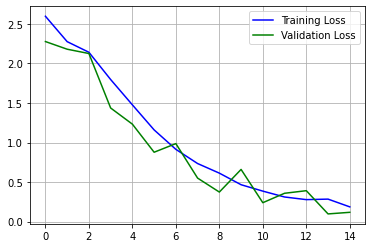

In [ ]:
training_loss = fit.history['loss']
validation_loss = fit.history['val_loss']

training_acc = fit.history['accuracy']
validation_acc = fit.history['val_accuracy']

plt.plot(fit.epoch,training_loss,label='Training Loss',color='blue')
plt.plot(fit.epoch,validation_loss,label='Validation Loss',color='green')
plt.legend()
plt.grid(True)


Na primeira vez em que o código foi executado, a acuracia no epoch 1 foi de 0.1206 e um Loss gigantesco. Após passar por todas as epochs a acuracia final do modelo treinado foi de 0.9402 com um Loss consideravelmente menor do que o inicial.

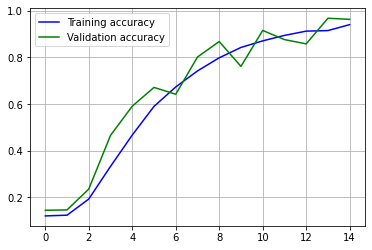

In [ ]:
plt.plot(fit.epoch,training_acc,label='Training accuracy',color='blue')
plt.plot(fit.epoch,validation_acc,label='Validation accuracy',color='green')
plt.legend()
plt.grid(True)
print()

# Aplicando nosso modelo nos dados de teste:

In [ ]:
perda, acuracia = nemo_finder.evaluate(test_generator)

22/22 [==============================] - 14s 619ms/step - loss: 0.0952 - accuracy: 0.9667


In [ ]:
print(f'Perda: {perda:.5f} \nAcuracia: {acuracia*100:.2f}%')

Perda: 0.09521 
Acuracia: 96.67% 


In [ ]:
# Continuando o desenvolvivendo, carregando o modelo do arquivo para nao precisar treinar novamente:
from tensorflow import keras
nemo_finder_imported = keras.models.load_model('/content/nemo_finder.h5')

In [ ]:
pred = nemo_finder_imported.predict(test_generator) # Retorna probabilidades
classes_pred = np.argmax(pred,axis=1) # Obtem o index com a maior probabilidade, esse sera o index da classe
classes_pred[:5] # Mostrando os 5 primeiros resultados

array([3, 1, 4, 0, 8])

In [ ]:
LABELS = test_generator.class_indices
LABELS

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
# Invertendo esse dicionario
Labeled_dict = { value: key for (key,value) in LABELS.items()}
Labeled_dict

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [ ]:
# Finalmente, pegando nossas classes

pred_labeled = [Labeled_dict[i] for i in classes_pred]
pred_labeled[:5]

['Red Mullet', 'Gilt-Head Bream', 'Red Sea Bream', 'Black Sea Sprat', 'Trout']

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test['Label'])

print(classification_report(y_test, pred_labeled))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      0.99       152
   Gilt-Head Bream       0.99      1.00      0.99       157
   Hourse Mackerel       0.99      0.98      0.99       139
        Red Mullet       0.99      0.98      0.98       165
     Red Sea Bream       0.99      0.99      0.99       155
          Sea Bass       0.98      0.99      0.98       160
            Shrimp       0.99      0.99      0.99       140
Striped Red Mullet       0.97      0.97      0.97       156
             Trout       0.99      1.00      1.00       126

          accuracy                           0.99      1350
         macro avg       0.99      0.99      0.99      1350
      weighted avg       0.99      0.99      0.99      1350



In [ ]:
list(LABELS.keys())

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

Text(0.5, 1.0, 'CONFUSION MATRIX')

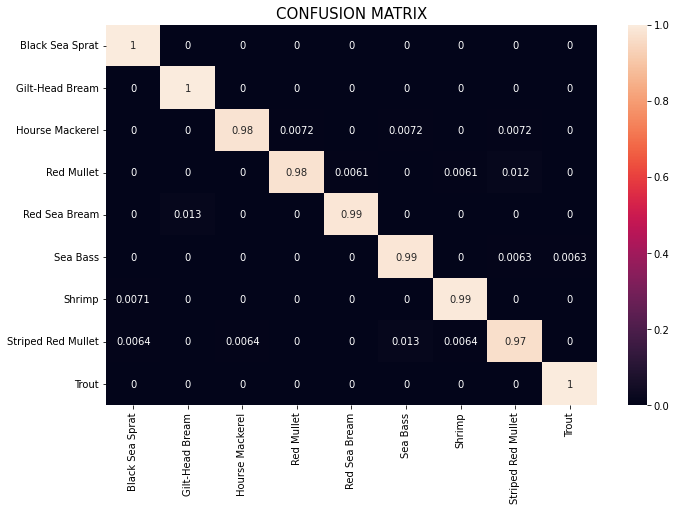

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Criando a confusion matrix
cf = confusion_matrix(y_test,pred_labeled,normalize='true',labels=list(LABELS.keys()))

# Plotando para visualizacao
plt.figure(figsize=(11,7))
sns.heatmap(cf,xticklabels=list(LABELS.keys()),yticklabels=list(LABELS.keys()),annot=True)
plt.title("CONFUSION MATRIX",fontsize=15)

# Aplicando o modelo em um problema de classificacao do mundo real kkkkk:

(1792, 828, 3)


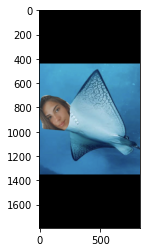

In [ ]:
import cv2
mayarraia = cv2.imread('/content/mayarraia.PNG')
mayarraia = cv2.cvtColor(mayarraia,cv2.COLOR_BGR2RGB)
print(mayarraia.shape)
plt.imshow(mayarraia)

(224, 224, 3)


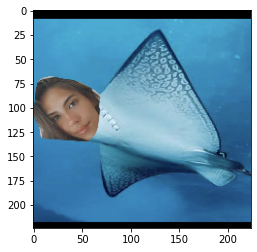

In [ ]:
# Preparando a imagem para ser aceita pela rede
mayarraia = mayarraia[400:1380,:,:] # Tirando essas margem preta do topo e do canto inferior
small_mayarraia = cv2.resize(mayarraia,(224,224))
print(small_mayarraia.shape)
plt.imshow(small_mayarraia)


In [ ]:
# Expandindo a dimensao, pra poder trabalhar com tensores
small_mayarraia = np.expand_dims(small_mayarraia,axis=0)
small_mayarraia.shape

(1, 224, 224, 3)

In [ ]:
mayarraia_species = nemo_finder_imported.predict(small_mayarraia)
print(mayarraia_species)
mayarraia_class = np.argmax(mayarraia_species)
print(mayarraia_class)

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
8


In [ ]:
 print(Labeled_dict[mayarraia_class])

Trout


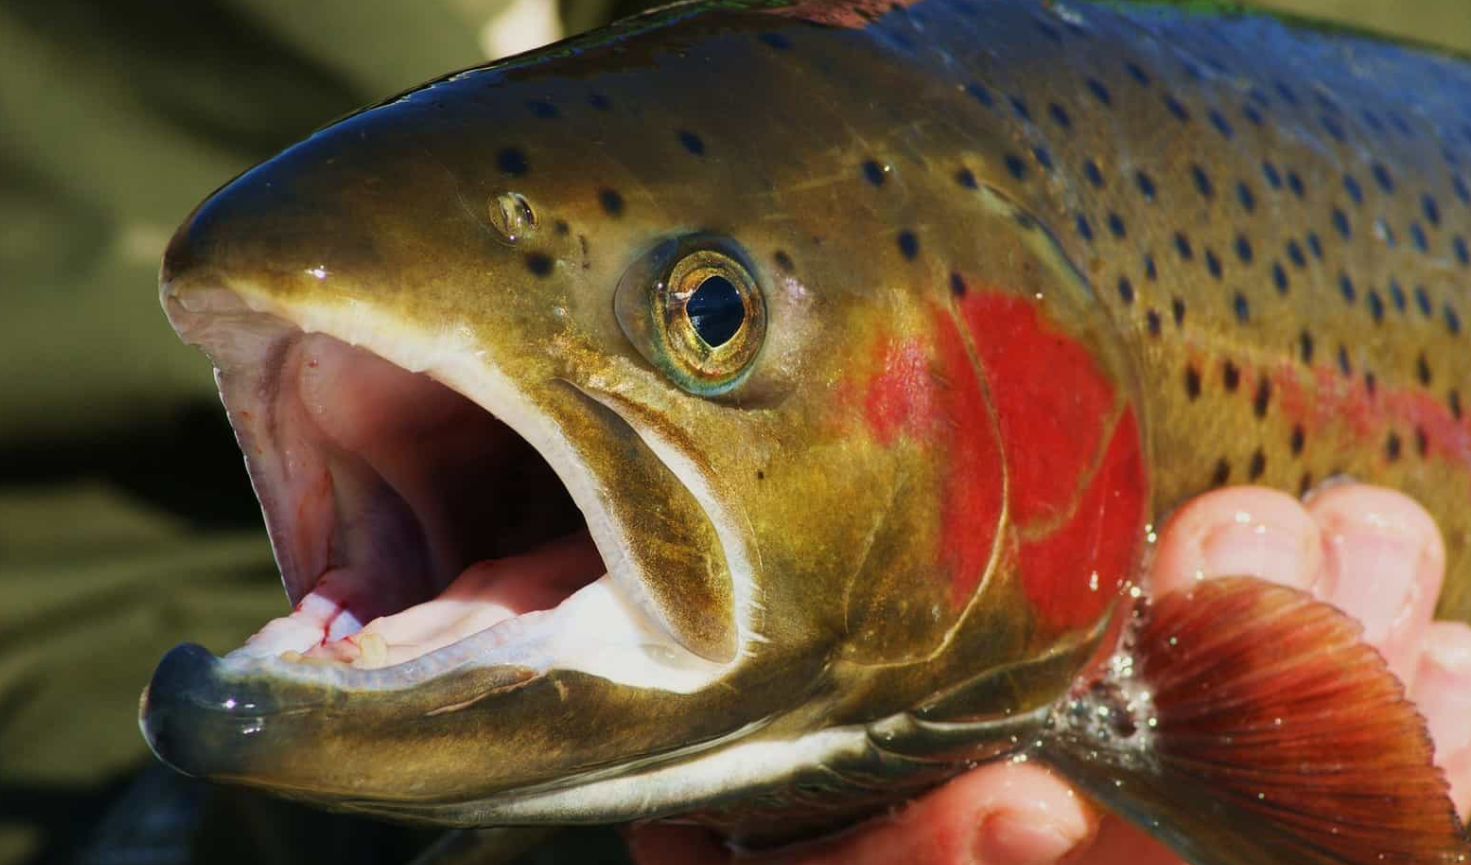